In [133]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from collections import Counter 
import re
from scipy import stats
import numpy as np

In [166]:
df2 = pd.read_json("./dataset/train.json")
df2.head(1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


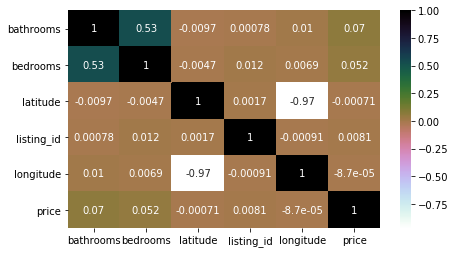

In [129]:
plt.figure(figsize=(7,4))
sns.heatmap(df2.corr(), annot=True, cmap='cubehelix_r')
plt.show()
# bathrooms and bedrooms are correlated - 0.53
# longitude and latitude are uncorrelated
# bathrooms and price are correlated - 0.07
# bedrooms and price are correlated - 0.052

In [130]:
# Remove Outliers and Drop Empty Fields
newdf2 = df2[(df2['description'] != '') & (df2['description'] != '<p><a  website_redacted')]
newdf2 = newdf2[newdf2['display_address'] != '']
newdf2 = newdf2[newdf2['features'].str.len() > 0]
newdf2 = newdf2[(newdf2['interest_level'] == 'low') | (newdf2['interest_level'] == 'medium') | (newdf2['interest_level'] == 'high')]
newdf2 = newdf2[(newdf2['price'] != 10) & (newdf2['price'] != 0)]
newdf2 = newdf2[newdf2['latitude'] != 0]
newdf2 = newdf2[newdf2['longitude'] != 0]
newdf2 = newdf2[newdf2['photos'].str.len() > 0]
newdf2 = newdf2[newdf2['street_address'].str.len() > 0]

newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bathrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['bedrooms'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['latitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['longitude'])) < 3)]
newdf2 = newdf2[(np.abs(stats.zscore(newdf2['price'])) < 3)]

In [115]:
# indexes = list(newdf2.index.values.tolist())
# values = list(newdf2['price'][indexes])
    
# plt.scatter(indexes, df2['price'][indexes], edgecolor = 'black')
# plt.xlabel('indexes')
# plt.ylabel('Number of Bedrooms')
# plt.show()
# newdf2['price'].describe()

In [131]:
newdf2['features'].head(5)

4     [Dining Room, Pre-War, Laundry in Building, Di...
6     [Doorman, Elevator, Laundry in Building, Dishw...
9     [Doorman, Elevator, Laundry in Building, Laund...
15    [Doorman, Elevator, Fitness Center, Laundry in...
16    [Doorman, Elevator, Loft, Dishwasher, Hardwood...
Name: features, dtype: object

In [153]:
# show {index # : {# of features : [list of features]}
# dct = {}
# indexes = list(newdf2.index.values.tolist())
# for index in indexes:
#     values = list(newdf2['features'][index])
#     feature_info = {}
#     feature_count = len(values)
# #     print(values)
#     dct[index] = feature_info
#     feature_info[feature_count] = values
# dct

In [161]:
# Createa new column of the total count of text features for each row
dct = {}
indexes = list(newdf2.index.values.tolist())
text_features_count = []
for index in indexes:
    values = list(newdf2['features'][index])
    text_features_count.append(len(values))
# dct

newdf2['text_features_count'] = text_features_count
# newdf2.head(8)

In [162]:
# label interest_level = row : 2
# label interest_level = medium : 1
# label interest_level = high : 0
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
newdf2["interest_level_code"] = lb_make.fit_transform(newdf2["interest_level"])
newdf2.head(1)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,text_features_count,interest_level_code
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,7,2


In [209]:
import time
from datetime import datetime

indexes = list(newdf2.index.values.tolist())
datetime_float = []
for index in indexes:
    datetime_obj = datetime.strptime(newdf2['created'][index], '%Y-%m-%d %H:%M:%S') 
    datetime_sec = time.mktime(datetime_obj.timetuple())
    datetime_float.append(datetime_sec)
#     Convert float to datetime obj
#     datetime_obj_after = datetime.fromtimestamp(datetime_sec) 
#     print(datetime_obj, "=>", datetime_sec, "=>", datetime_obj_after)
#     print(type(datetime_sec)) // float
newdf2['datetime_float'] = datetime_float
newdf2.head(2)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,text_features_count,interest_level_code,datetime_float
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,7,2,1.466082e+09
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,6,1,1.464785e+09


In [212]:
# cvObjParser.py

import cvlib as cv
import cv2
from cvlib.object_detection import draw_bbox
import numpy as np
import sys
import os

# usage: python3 cvObjParser.py [0:no output, 1:output] [image folder path]

# check if want to see image output with first argument (iterate through images with 'q')
check_output = sys.argv[1]

# maps frequency of features
def frequency(features):
    freq = {}
    for feature in features:
        freq[feature] = features.count(feature)
    #for key, value in freq.items():
        #print("% s: % s"%(key, value))
    return freq

# take image folder as argument & extract image paths
folder_path = sys.argv[2]
images = []
for r, d, f in os.walk(folder_path):
    for file in f:
        if '.jpg' in file:
            images.append(os.path.join(r, file))

# extract features from collection of images
img_contrasts = []
features = []
for image in images:
    
    in_img = cv2.imread(image)

    # show original image
    '''
    cv2.imshow('Image', in_img)
    cv2.waitKey()
    '''
 
    # check contrast
    c = cv2.cvtColor(in_img, cv2.COLOR_BGR2YUV)[:,:,0]
    c_min = float(np.min(c))
    c_max = float(np.max(c))
    contrast = (c_max-c_min)/(c_max+c_min)
    img_contrasts.append(round(contrast, 2))
    
    # perform analysis
    bbox, label, conf = cv.detect_common_objects(in_img)
    out_img = draw_bbox(in_img, bbox, label, conf)
    
    # show output image
    '''
    '''
    if check_output == '1':
        cv2.imshow('labeled', out_img)
        cv2.waitKey()
    
    # show features extracted
    for l in label:
        features.append(l)

# filter features into important ones
f = frequency(features)
print('\nImages have the following features & frequencies\n================================================\n')
print(f)

# check if listing furnished
furn_count = 0
filt_feat = ['bench', 'chair', 'couch', 'bed', 'dining table', 'tv', 'clock', 'vase']
for item in filt_feat:
    if item in f:
        furn_count = furn_count+f[item]
print('\nthere are', furn_count, 'pieces of furniture')

# check for plants
plant_count = 0
filt_feat = 'potted plant'
if filt_feat in f:
    plant_count = plant_count+f[filt_feat]
print('there are', plant_count, 'plants')

# check contrast (avg < 0.9 not as nice looking)
avg = 0
for cont in img_contrasts:
    avg = avg+cont
avg = round(avg/len(img_contrasts), 2)
print('image contrast values are', img_contrasts, 'with an average of', avg)

# check if bathroom or kitchen is shown
kitchen = False
filt_feat = ['microwave', 'oven', 'toaster', 'refrigerator']
for item in filt_feat:
    if item in f:
        kitchen = True
if kitchen == True:
    print('Kitchen shown')
else: 
    print('Kitchen not shown')
bathroom = False
if 'toilet' in f:
    bathroom = True
    print('Bathroom shown')
else: 
    print('Bathroom not shown')


# check other features
print('there are', len(images), 'pictures')




ModuleNotFoundError: No module named 'cvlib'